**Requirements:** Please install NumPyro by running:

```$ pip install --upgrade numpyro```

In [1]:
from functools import partial

# Ordinary Numpy (without an autograd/JAX wrapper around it)
import numpy as np
import numpyro
import pandas as pd
import scipy.stats
from sklearn.isotonic import IsotonicRegression
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

from bnn import feedforward
from calibration import QuantileCalibration
from data import generate_data
from inference import sample, simulate_pp, fit_advi, run_diagnostics
from plotting import *

In [2]:
# Configure matplotlib format and default dimensions
%config InlineBackend.figure_formats = ['svg']
plt.rc("figure", figsize=(7, 3.5))

# Perform inference using a CPU and 2 cores
numpyro.set_platform("cpu")
numpyro.set_host_device_count(2)

# Visualize all posterior predictive checks if in debug mode
DEBUG = False

In [3]:
def build_model(df, *, hidden, width, sigma, noise):
    """Instantiate the a feedforward BNN model with a network architecture,
    prior standard deviation and likelihood noise.

    Args:
        df: a pandas DataFrame of observations (x, y)
        hidden: the number of hidden layers in a BNN
        width: the number of nodes in each hidden player
        sigma: the standard deviation of the prior on the network weights
        noise: the standard deviation of the likelihood noise

    Returns:
        model: an instantiated NumPyro model function
    """
    X = df[["x"]].values
    Y = df[["y"]].values

    model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

    return model


In [4]:
def sample_and_plot(df, func, *, hidden, width, sigma, noise, num_samples, num_warmup, num_chains=2):
    """A helper function to instantiate the model, sample from the posterior, simulate
    the posterior predictive and plot it against the observations and the true function.

    Args:
        df: a pandas DataFrame of observations (x, y)
        func: the true function, a scipy.stats distribution for plotting
        hidden: the number of hidden layers in a BNN
        width: the number of nodes in each hidden player
        sigma: the standard deviation of the prior on the network weights
        noise: the standard deviation of the likelihood noise
        num_samples: the number of samples to draw in each chain
        num_warmup: the number of samples to use for tuning in each chain
        num_chains: the number of chains to draw (default: {2})

    Returns:
        mcmc: a fitted MCMC inference object.
        mcmc.print_summary() can be used for detailed diagnostics
    """
    # Instantiate the model
    model = build_model(df, width=width, hidden=hidden, sigma=sigma, noise=noise)

    # Run the No-U-Turn sampler
    mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=False)

    # Generate the posterior predictive
    X_test = np.linspace(df.x.min(), df.x.max(), num=1000)[:, np.newaxis]
    posterior_predictive = simulate_pp(model, mcmc, X_test, seed=1)

    # Plot the posterior predictive
    plot_posterior_predictive(
        X_test,
        posterior_predictive,
        func=func,
        df=df,
        title=f"BNN with {width} Nodes in {hidden} Hidden Layer{'' if hidden == 1 else 's'},\n"
        f"Weight Uncertainty {sigma}, Noise {noise}, NUTS Sampling",
    )

    # Print the diagnostic tests
    diagnostics = run_diagnostics(mcmc)
    message = ("Minimum ESS: {min_ess:,.2f}\n" "Max Gelman-Rubin: {max_rhat:.2f}").format(
        **diagnostics
    )
    plt.gcf().text(0.95, 0.15, message)

    # Return the fitted MCMC object to enable detailed diagnostics, e.g. mcmc.print_summary()
    return mcmc

In [5]:
def fit_and_plot(df, func, *, hidden, width, sigma, noise, num_iter, learning_rate):
    """A helper function to instantiate the model, approximate the posterior using Variational Inference
    with reparametrization and isotropic Gaussians, simulate the posterior predictive and plot it
    against the observations and the true function.

    Args:
        df: a pandas DataFrame of observations (x, y)
        func: the true function, a scipy.stats distribution for plotting
        hidden: the number of hidden layers in a BNN
        width: the number of nodes in each hidden player
        sigma: the standard deviation of the prior on the network weights
        noise: the standard deviation of the likelihood noise
        num_iter: the number of iterations of gradient descent (Adam)
        learning_rate: the step size for the Adam algorithm (default: {0.01})

    Returns:
        vi: an collection of fitted VI objects, an instance of ADVIResults.
        vi.losses or vi.plot_loss() can be used for diagnostics of the ELBO.
    """
    # Instantiate the model
    model = build_model(df, width=width, hidden=hidden, sigma=sigma, noise=noise)

    # Approximate the posterior using Automatic Differentiation Variational Inference
    vi = fit_advi(model, num_iter=num_iter, learning_rate=learning_rate, seed=0)

    # Generate the posterior predictive and plot the results
    X_test = np.linspace(df.x.min(), df.x.max(), num=1000)[:, np.newaxis]
    posterior_predictive = simulate_pp(model, vi, X_test, n_samples=5000, seed=1)

    # Plot the posterior predictive
    plot_posterior_predictive(
        X_test,
        posterior_predictive,
        func=func,
        df=df,
        title=f"BNN with {width} Nodes in {hidden} Hidden Layer{'' if hidden == 1 else 's'},\n"
        f"Weight Uncertainty {sigma}, Noise {noise}, VI Approximation",
    )
    # Return the variation inference object to enable diagnostics, e.g. vi.plot_loss()
    return vi

In [6]:
def calibrate(df_main, df_hold, *, hidden, width, sigma, noise, inference="NUTS", **kwargs):
    """A helper function to instantiate BNNs for both datasets, sample from the posterior,
    simulate the posterior predictives and train isotonic regression.

    Args:
        df_main: the main dataset (x, y) that need to be recalibrated, a pandas DataFrame
        df_hold: the hold-out dataset (x, y) to train isotonic regression on, a pandas DataFrame
        hidden: the number of hidden layers in a BNN
        width: the number of nodes in each hidden player
        sigma: the standard deviation of the prior on the network weights
        noise: the standard deviation of the likelihood noise
        inference: a method of interence, either "NUTS" or "VI" (default: {"NUTS"})
        **kwargs: additional arguments passed along to the NUTS sampler or to the VI optimizer

    Returns:
        res_main, res_holdout: dictionaries holding fitted inference objects, including
            the posterior predictive
        qc: an instance of QuantileCalibration, containing isotonic regression trained
            in forward an in reverse modes.
    """
    assert inference in {"NUTS", "VI"}, "Inference method must be one of 'NUTS' or 'VI'"
    results = []

    # Obtain the posterior predictives for both datasets
    for df in [df_main, df_hold]:
        # Instantiate the model
        model = build_model(df, width=width, hidden=hidden, sigma=sigma, noise=noise)

        if inference == "NUTS":
            # Sample from the posterior using the No-U-Turn sampler
            infer = sample(model, seed=0, summary=False, **kwargs)
            # Use all posterior samples to generate the posterior predictive
            n_samples = None
        elif inference == "VI":
            infer = fit_advi(model, seed=0, **kwargs)
            n_samples = 5000

        X_test = np.linspace(df.x.min(), df.x.max(), num=1000)[:, np.newaxis]

        # Simulate the posterior predictive for equally spaced values of X for plotting
        post_pred = simulate_pp(model, infer, X_test, n_samples=n_samples, seed=1)
        # Simulate the posterior predictive for all X's in the dataset
        post_pred_train = simulate_pp(model, infer, df[["x"]].values, n_samples=n_samples, seed=1)

        # Collect the results
        results.append(
            {
                "df": df,
                "model": model,
                "infer": infer,
                "X_test": X_test,
                "post_pred": post_pred,
                "post_pred_train": post_pred_train,
            }
        )

    res_main, res_holdout = results

    # Train isotonic regression on the hold-out dataset
    qc = QuantileCalibration()
    qc.fit(res_holdout["df"].y, res_holdout["post_pred_train"])

    return res_main, res_holdout, qc

# Accurate Uncertainties for Deep Learning Using Calibrated Regression

Analysis of the paper by [Kuleshov et al. (2018)](https://arxiv.org/pdf/1807.00263)

Project team: Piotr Pekala, Benjamin Yuen, Dmitry Vukolov, Alp Kutlualp

# Outline

1. Problem Statement: Miscalibration and its Sources
2. Existing work
3. Contribution: The Calibration Algorithm
4. Technical Details
5. Experiments
6. Evaluation of the claims
7. Future work

# Problem Statement

# The Issue of Miscalibration

**Problem statement:** Proper quantification of uncertainty is crucial for applying statistical models to real-world situations. The Bayesian approach to modeling provides us with a principled way of obtaining such uncertainty estimates. Yet, due to various reasons, such estimates are often inaccurate. For example, a 95% posterior predictive interval does not contain the true outcome with 95% probability. Such a model is *miscalibrated*.

**Context:** <mark>why is this problem important or interesting? any examples?</mark>

# Sources of Miscalibration

Below we demonstrate that the problem of miscalibration exists and show why it exists for **Bayesian neural networks** in regression tasks. We focus on the following sources of miscalibration:
- The **prior** is wrong, e.g. too strong and overcertain
- The **likelihood function** is wrong. There is bias, i.e. the neural network is too simple and is unable to model the data.
- The **noise** specification in the likelihood is wrong.
- The **inference** is approximate or is performed incorrectly.

Our aim is to establish a causal link between each aspect of the model building process and a bad miscalibrated outcome.

# Methodology

1. **Data Generation:** We generate the data from a known true function with Gaussian noise. We then build multiple feedforward BNN models using:
  - different network architectures
  - several priors on the weights, depending on model complexity
  - different variance of the Gaussian noise in the likelihood function
  
2. **Inference**: We then obtain the posterior of the model by:
  - sampling from it with the No-U-Turn algorithm
  - approximating the posterior using Variational Inference with reparametrization and isotropic normals
  
3. **Diagnostics**: We check for convergence using trace plots, the effective sample size, and Gelman-Rubin tests. In the case of variational inference, we track the ELBO during optimization. The simulated posterior predictive is evaluated visually.

The probabilistic library [NumPyro](https://github.com/pyro-ppl/numpyro) provides fast implementations of both algorithms, which we make use of in this research. Due to time constraints we do not perform multiple random restarts, so the results may be subject to randomness.

# Example: a Toy Dataset

Using a simple data-generating function $y_i = 0.1 x^3_i + \varepsilon$, where $\varepsilon \sim \mathcal{N}(0, 0.5^2)$ and a series of BNN models we evaluate the impact of our design choices on the posterior predictive.

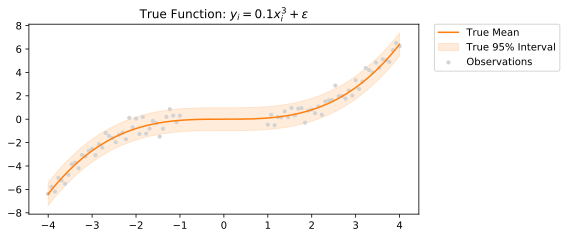

In [7]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 40, "xlim": [-4, -1]},
    {"n_points": 40, "xlim": [1, 4]},
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

# Proper Posterior Predictive

A neural network with 50 nodes in a single hidden layer, well-chosen prior and noise, as well as correctly performed inference using sampling produce a posterior predictive that adequately reflects both epistemic and aleatoric uncertainty:

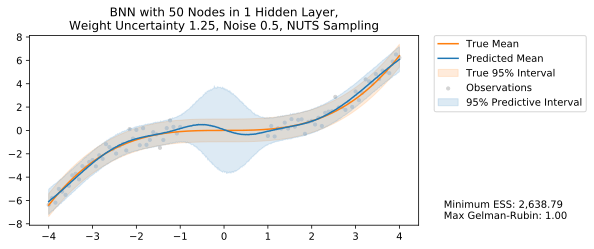

In [8]:
# Parameters of the Bayesian neural network
model_params = {
    # Number of hidden layers
    "hidden": 1,
    # Width of hidden layers
    "width": 50,
    # Standard deviation of the prior
    "sigma": 1.25,
    # Standard deviation of the likelihood
    "noise": 0.5,
}

# NUTS sampler parameters
sampler_params = {
    "num_samples": 2000,
    "num_warmup": 2000,
    "num_chains": 2,
}

# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

Naturally, our claims regarding the adequacy of epistemic uncertainty are subjective due to the absence of universal quantitative metrics.

# Wrong Prior: Too Wide

The prior on the network weights defines epistemic uncertainty. A higher than necessary variance of the prior results in a significantly larger and most likely unreasonable epistemic uncertainty:

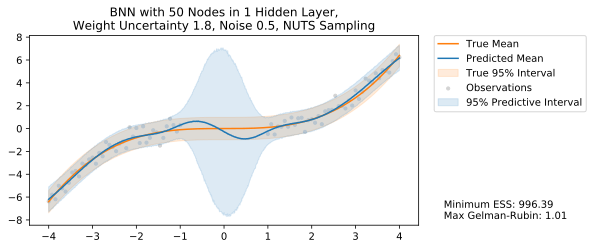

In [9]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.8,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Prior: Too Narrow

Lower variance of the prior prevents the model from adequately reflecting epistemic uncertainty in areas where no data is available. It also introduces bias: a neural network with 50 nodes in a single hidden layer (i.e. 151 weights) is unable to fit a cubic function:

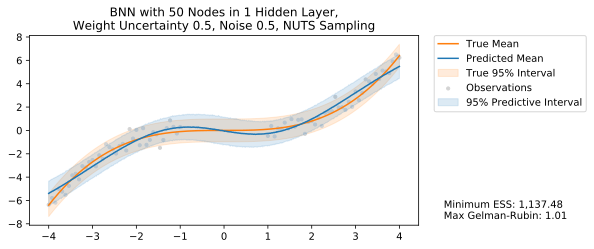

In [10]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 0.5,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Prior: Extremely Restrictive

The bias becomes apparent with an even narrower prior on the weights. This is a major issue with the model that needs to be fixed. Calibration is inappropriate in this case.

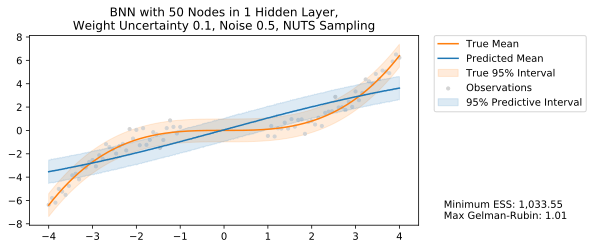

In [11]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 0.1,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Likelihood Function

Similar to the previous example, a BNN may demonstrate bias by beeing too simple architecturally. That is difficult to demonstrate for a dataset generated by a cubic function (can be described by just 4 points). Still, we can try a combination of the prior and noise specification from the proper model and reduce the number of nodes. The sampler does not converge in this setup.

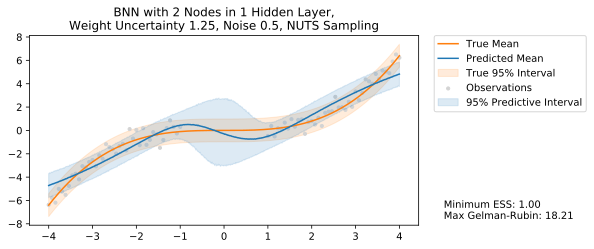

In [12]:
model_params = {
    "hidden": 1,
    "width": 2,
    "sigma": 1.25,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Link Between Prior and Network Architecture

The appropriate level of the prior variance depends on the network complexity. A simpler network with 10 nodes and the same prior variance as our original benchmark model predicts much lower epistemic uncertainty. Therefore, the prior has to be selected for each particular network configuration.

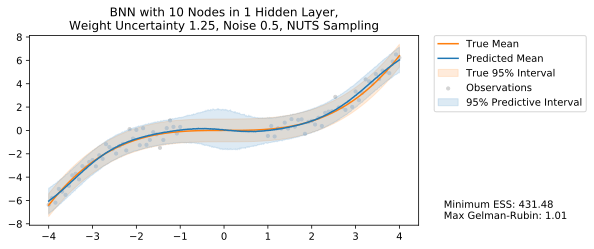

In [13]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 1.25,
    "noise": 0.5,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Wrong Noise: Too High

The noise in the likelihood function corresponds to aleatoric uncertainty. The effect of the wrong noise specification is that aleatoric uncertainty is captured incorrectly. In the model below the noise is still Gaussian, but has a higher variance than the true one:

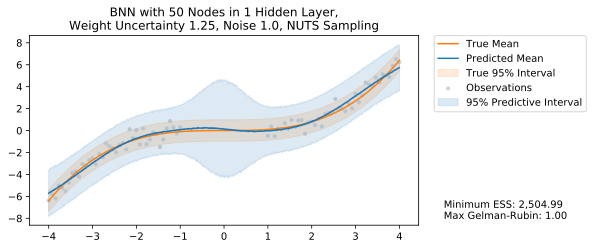

In [14]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 1.0,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

This might be a good candidate for calibration. Alternatively, one could find ways for the network to learn the noise from the data or put an additional prior on the variance of the noise.

# Wrong Noise: Too Small

Similarly, if the noise is too small, the resulting aleatoric uncertainty captured by the posterior predictive will be unrealistically low:

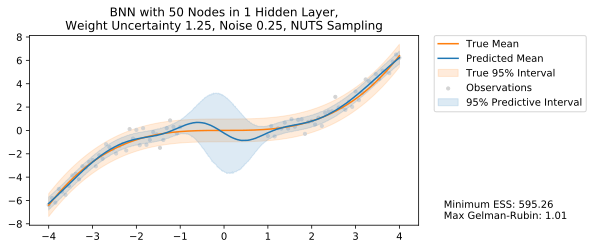

In [15]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 0.25,
}
# Run the No-U-Turn sampler, generate the posterior predictive and plot it
mcmc = sample_and_plot(df, func, **model_params, **sampler_params)

# Approximate Inference

Using approximate methods of inference is also likely to lead to a miscalibrated posterior predictive. In the example below, Variational Inference with reparametrization on a network with 50 nodes produces too low epistemic uncertainty and slightly larger aleatoric uncertainty. Calibration may be used for correcting the latter.

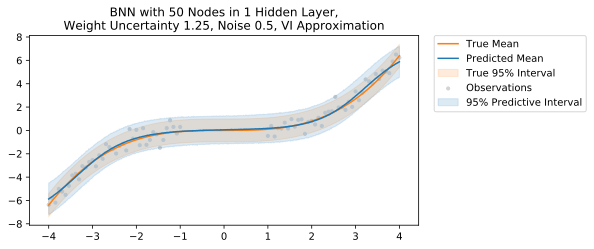

In [16]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 0.5,
}

vi_params = {
    "num_iter": 500_000,
    "learning_rate": 0.001,
}

# Approximate the posterior with Variational Inference, generate the posterior predictive and plot it
vi = fit_and_plot(df, func, **model_params, **vi_params)

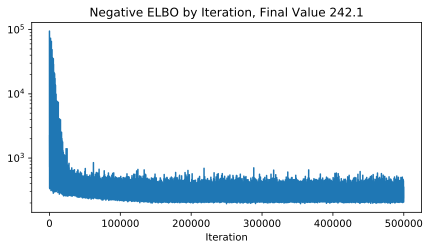

In [17]:
# Plot the negative ELBO for diagnostics
vi.plot_loss()

# Existing Work

# Literature Review

<mark>To be filled...</mark>

# Contribution: The Calibration Algorithm

# The Calibration Algorithm

**Proposition:** The authors of the paper propose a simple **calibration algorithm** for regression. In the case of Bayesian models, the procedure ensures that uncertainty estimates are well-calibrated, given enough data. In other words, the resulting posterior predictive aligns with the data, i.e. the observations fall within each posterior predictive interval  (e.g. the 95% interval) with a corresponding probability.

###### Unique Contribution:
- The procedure is universally applicable to any **regression** model, be it Bayesian or frequentist. It extends previous work on calibration methods for classification.
- Compared to alternative approaches, the method doesn't require modification of the model. Instead, the algorithm is applied to the output of any existing model in a postprocessing step.

**Claim:** The authors claim that the method outperforms other techniques by consistently producing well-calibrated forecasts, given enough i.i.d. data. Based on their experiments, the procedure also improves predictive performance in several tasks, such as time-series forecasting and reinforcement learning.

# Technical Details

# Recalibration of Regression Models

The algorithm has two main steps (from Algorithm 1 listing in the paper):
1. Construct a recalibration dataset $\mathcal{D}$:
$$
\mathcal{D} = \left\{\left(\left[H\left(x_t\right)\right]\left(y_t\right), \hat P\left(\left[H\left(x_t\right)\right]\left(y_t\right)\right)\right)\right\}_{t=1}^T
$$
where:
 - $T$ is the number of observations
 - $H(x_t)$ is a CDF of the posterior predictive evaluated at $x_t$
 - $H(x_t)(y_t)$ is the predicted quantile of $y_t$
 - $\hat P(p)$ is the empirical quantile of $y_t$, computed as:
 
  $$
  \hat P(p)=\left|\left\{y_t\mid \left[H\left(x_t\right)\right]\left(y_t\right)\lt p, t=1\ldots T\right\}\right|/T
  $$


2. Train a model $R$ (e.g. isotonic regression) on $\mathcal{D}$.

# The Algorithm Step-by-Step

Suppose we have the following hypothetical posterior predictive, which is heteroscedastic and is underestimating uncertainty. For each value of the covariate $X$, the posterior predictive provides us with a conditional distribution $f(Y|X)$:

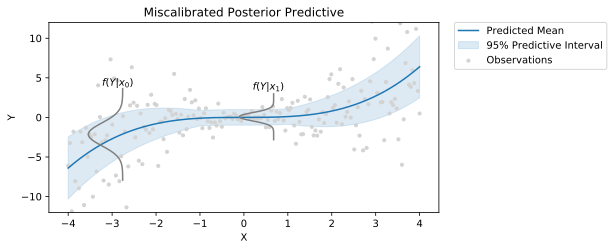

In [18]:
def heteroscedastic_base(x, base_std):
    """A heteroscedastic function that serves as the basis for
    the true function and a hypothetical posterior predictive.
    """
    std = np.abs(x) * base_std
    std = np.where(std < 0.5, 0.5, std)
    return scipy.stats.norm(loc=0.1 * x ** 3, scale=std)

# The true function
true_func = lambda x: heteroscedastic_base(x, base_std=1.5)
# A miscalibrated posterior predictive that underestimates uncertainty
ppc = lambda x: heteroscedastic_base(x, base_std=0.5)

# Generate observations for an equally sized train set and a test set
data_points = [
    {"n_points": 200, "xlim": [-4, 4]},
]
df = generate_data(true_func, points=data_points, seed=4)
df_test = generate_data(true_func, points=data_points, seed=0)


def ppc_quantiles(y, x=df.x):
    """Return the predicted quantiles of y_t evaluated at x_t.
    Here we do it analytically, but in practice the quantiles are estimated based on the samples.
    """
    return ppc(x).cdf(y)

# Visualize an illustrative miscalibrated posterior predictive
plot_illustration(ppc, df, title=f"Miscalibrated Posterior Predictive", conditionals=True)

# Step 1: Construct a Recalibration Dataset

The first step of the calibration algorithm is to obtain predictive conditional distributions for each 𝑋 in the dataset. If no closed-form is available we simulate the posterior predictive based on the samples of the posterior:

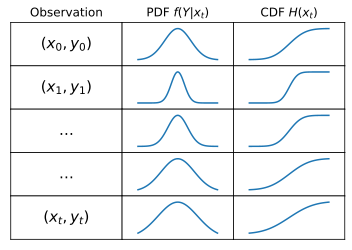

In [19]:
plot_table()

An alternative, more commonly used notation for $H(x_t)$ is $F_t$ (a CDF)

# Step 1a: Compute the Predicted Quantiles

The observed $Y$ for each data point falls somewhere within those conditional distributions. We evaluate the conditional CDFs at each observed value of the response $Y$ to obtain the predicted quantiles. In the absence of analytical form, we simply count the proportion of samples that are less than $y_t$. This gives us the estimated quantile of $y_t$ at $x_t$ in the posterior predictive distribution:

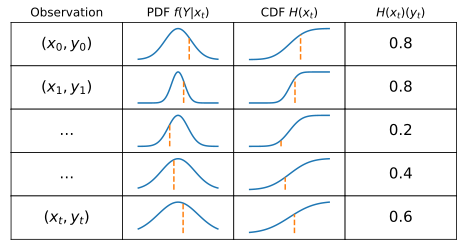

In [20]:
plot_table(mark_y=True, show_quantiles="predicted")

# Step 1b: Estimate the Empirical Quantiles

We next find the empirical quantiles, which are defined as the proportion of observations that have lower quantile values than that of the current observation. This is equivalent to finding the empirical CDF of the predicted quantiles. The mapping of predicted quantiles and the empirical quantiles will form a recalibration dataset:

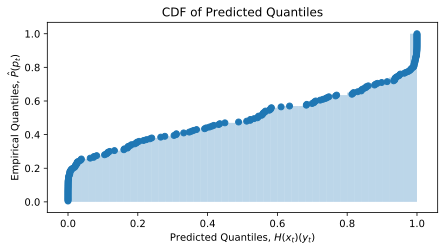

In [21]:
# Estimate the predicted quantiles
predicted_quantiles = ppc_quantiles(df.y)

# Compute the empirical quantiles
T = predicted_quantiles.shape[0]
empirical_quantiles = (predicted_quantiles.reshape(1, -1) 
                       <= predicted_quantiles.reshape(-1, 1)).sum(axis=1) / T

# Plot the predicted against the empirical quantiles
plot_ecdf(predicted_quantiles)
plt.scatter(predicted_quantiles, empirical_quantiles, color="tab:blue", zorder=2);

# Step 1c: Form a Recalibration Dataset

The mapping is obtained for all observations in the dataset. Note that in this example the first two observations have different conditional distributions, but the same values of the predicted and empirical quantiles. The calibration procedure doesn't distinguish between such cases:

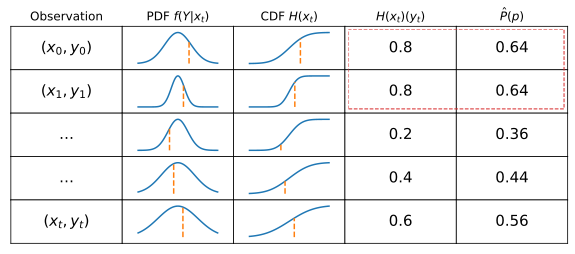

In [22]:
plot_table(mark_y=True, show_quantiles="all")

# Step 1c: Form a Recalibration Dataset

The inverse S-curve of the recalibration dataset in our example is characteristic of a posterior predictive that underestimates uncertainty. The diagnonal line denotes perfect calibration:

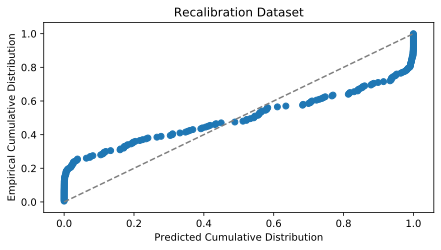

In [23]:
# Visualize the recalibration dataset
plt.scatter(predicted_quantiles, empirical_quantiles)
plt.plot([0, 1], [0, 1], color="tab:grey", linestyle="--")
plt.xlabel("Predicted Cumulative Distribution")
plt.ylabel("Empirical Cumulative Distribution")
plt.title("Recalibration Dataset");

# Step 2: Train a Model

We then train a model (e.g. isotonic regression) on the recalibration dataset and use it to output the actual probability of any given quantile or interval. Here the 95% posterior predictive interval corresponds to a much narrower calibrated interval:

In [24]:
# Fit isotonic regression
ir = IsotonicRegression(out_of_bounds="clip")
ir.fit(predicted_quantiles, empirical_quantiles)

# Obtain actual calibrated quantiles
calibrated_quantiles = ir.predict([0.025, 0.5, 0.975])
table = (
    pd.DataFrame(
        {"Predicted quantiles": [0.025, 0.5, 0.975], "Calibrated quantiles": calibrated_quantiles}
    )
    .round(3)
    .style.hide_index()
)
display(table)

Ideally, the model should be fit on a separate calibration set in order to reduce overfitting. Alternatively, multiple models can be trained in a way similar to cross-validation:

- use $K-1$ folds for training
- use 1 fold for calibration
- at prediction time, the output is the average of $K$ models

# Detailed Steps (Part 1)

Concretely, for models without closed form posterior predictive CDF, the calibration algorithm is restated as:
1. Generate $N$ samples from the posterior, $\theta = \left\{\theta_n, n=1\ldots N\right\}$.
2. For each observation, $t \in 1\ldots T$
    * Generate $N$ samples of posterior predictive, $s_{t_n}$, from $\theta$ and evaluated at $x_t$
    * Let $p_t$ be the quantile of $y_t$. Estimate the quantile of $y_t$ as
    $$p_t = \widehat{\left[H(x_t)\right](y_t)} = \left|\left\{s_{t_n}\mid s_{t_n} \le y_t,n=1\ldots N\right\}\right|/N$$
3. For each $t$
    * calculate $\hat P\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}\right) = \hat P\left(p_t\right)$ as
    $$\hat P\left(p_t\right) = \left|\left\{p_u\mid p_u\lt p_t, u=1\ldots T\right\}\right|/T
    $$
    That is, find the proportion of observations that have lower quantile values than that of the current observation.

# Detailed Steps (Part 2)

4. Construct $\mathcal{D} = \left\{\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}, \hat P\left(\widehat{\left[H\left(x_t\right)\right]\left(y_t\right)}\right)\right)\right\}_{t=1}^T$
5. Train calibration transformation using $\mathcal{D}$ via isotonic regression (or other models). Running prediction on the trained model results in a transformation $R$, $[0,1] \to [0,1]$. We can compose the calibrated model as $R\circ H\left(x_t\right)$.
6. To find the calibrated confidence intervals, we need to remap the original upper and lower limits. For example, the upper limit $y_{t\ high}$ is mapped to the calibrated value $y_{t\ high}'$ as:
$$y_{t\ high}'=\left[H\left(x_t\right)\right]^{-1}\left(R^{-1}\left\{\left[H\left(x_t\right)\right]\left(y_{t\ high}\right)\right\}\right)$$

# Diagnostics

As a visual diagnostic tool, the authors suggest using a calibration plot that shows the true frequency of points in each quantile or confidence interval compared to the predicted fraction of points in that interval. Well-calibrated models should be close to a diagonal line:

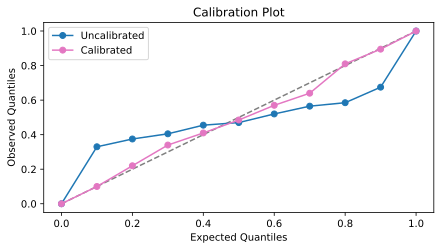

In [25]:
# Perform calibration on a hold-out test dataset
predicted_quantiles_test = ppc_quantiles(df_test.y)
calibration_plot(predicted_quantiles_test, model=ir)

# Quantitative metrics

Several alternatives are available, each with specific advantages and disadvantages:

**1. Calibration error**
$$cal(F_1, y_1, ..., F_N, y_N ) = \sum_{j=1}^m w_j \cdot (p_j − \hat{p}_j)^2$$
Provides a synthetic measure representing the overall *'distance'* of the points on the calibration curve from the $45^\circ$ straight line. The weights ($w_j$) might be used to reduce the importance of intervals containing few observations. Value of $0$ indicates perfect calibration. Sensitive to binning.

**2. Predictive RMSE**
$$\sqrt{\frac{1}{N}\sum_{n=1}^{N}||y_n-\mathbb{E}_{q(W)}[f(x_n,W)]||_{2}^{2}}$$
Measures the model *fit* to the observed data by normalizing the difference between observations and the mean of the posterior predictive. Minimizing RMSE does not guarantee calibration of the model.

# Quantitative metrics cont.

**3. Mean prediction interval width**
$$\frac{1}{N}\sum_{n=1}^{N}\hat{y}_{n}^{high} - \hat{y}_{n}^{low},$$
where $\hat{y}_{n}^{high}$ and $\hat{y}_{n}^{low}$ are - respectively - the 97.5 and 2.5 percentiles of the predicted outputs for $x_n$.
Average difference between the the upper and lower bounds of predictive intervals evaluated for all the observations (different significance values might be used to define the predictive intervals). By itself provides information on the precision of the prediction (*confidence* with which a prediction is made) rather than calibration or miscalibration of the model. However may be used in conjunction with PICP.

**4. Prediction interval coverage probability (PICP)**
$$\frac{1}{N}\sum_{n=1}^{N}\mathbb{1}_{y_n\leq\hat{y}_{n}^{high}} \cdot \mathbb{1}_{y_n\geq\hat{y}_{n}^{low}}$$
Calculates the share of observations covered by 95% (or any other, selected) predictive intervals. Alignment of the PICP with the probability mass assigned to the predictive interval generating it may misleadingly point to proper calibration if true noise distribution belongs to a different family than the posterior predictive. Requires a large sample of observations. 

# Experiments

# Homoscedastic Dataset

Rather than try to reproduce the experiments from the paper we chose to run the calibration algorithm on a series of synthetic datasets. This allows us to analyze the effect of the procedure on different purposefully miscalibrated posterior predictives.

The first dataset is a cubic polynomial with homoscedastic Gaussian noise:

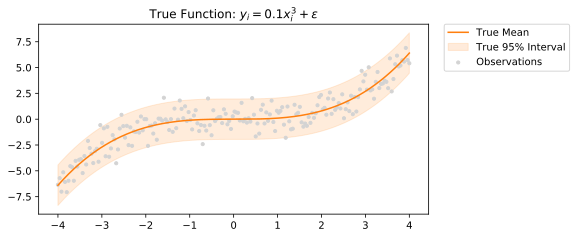

In [26]:
def polynomial(x):
    """True data-generating function"""
    return scipy.stats.norm(loc=0.1 * x ** 3, scale=1)

polynomial.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

# Generate observations for an equally sized main dataset 
# and a hold-out dataset to train isotonic regression on
data_points = [
    {"n_points": 200, "xlim": [-4, 4]},
]
df = generate_data(polynomial, points=data_points, seed=4)
df_hold = generate_data(polynomial, points=data_points, seed=1)

# Plot the data
plot_true_function(polynomial, df, title=f"True Function: {polynomial.latex}")

# Low Noise: Recalibration

Through sampling, we perform inference of a BNN that underestimates uncertainty (low variance of the noise in the likelihood). The calibration model is trained on a separated hold-out dataset of the same size. After calibration, the posterior predictive aligns with the data really well:

In [27]:
# Parameters of the Bayesian neural network
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 1.0,
    "noise": 0.5,
}

# NUTS sampler parameters
sampler_params_4k = {
    "num_samples": 4000,
    "num_warmup": 4000,
    "num_chains": 2,
}

# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params_4k)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func=polynomial, plot=DEBUG)

Main dataset: minimum ESS 738.31, maximum Gelman-Rubin 1.00
Hold-out dataset: minimum ESS 639.86, maximum Gelman-Rubin 1.01


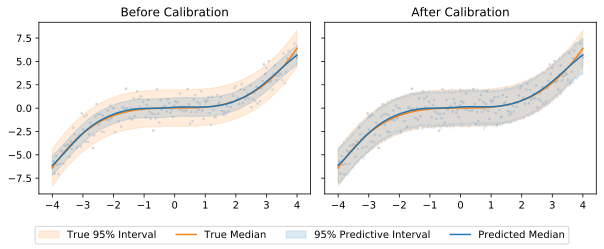

In [28]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=polynomial)

The calibrated posterior predictive isn't smooth due to sampling, which is especially evident for the extreme quantiles.

# High Noise: Recalibration

Similarly, excellent results are obtained when we apply the calibration algorithm to a BNN that overestimates uncertainty due to the high variance of the noise in the Gaussian likelihood function. The resulting posterior predictive captures aleatoric uncertainty well:

In [29]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 2.0,
    "noise": 1.5,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func=polynomial, plot=DEBUG)

Main dataset: minimum ESS 1,002.73, maximum Gelman-Rubin 1.00
Hold-out dataset: minimum ESS 917.04, maximum Gelman-Rubin 1.01


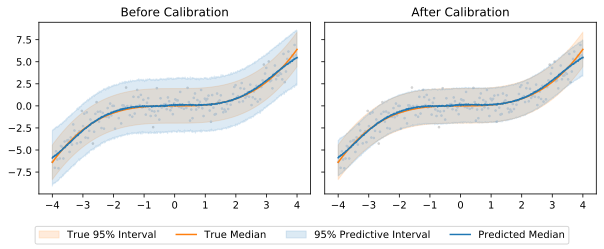

In [30]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=polynomial)

# The Case of Missing Data

The next dataset is the one we used previously in our miscalibration examples — a third-degree polynomial with a gap in the middle. This will allow us to evaluate the impact of the calibration algorithm on epistemic uncertainty.

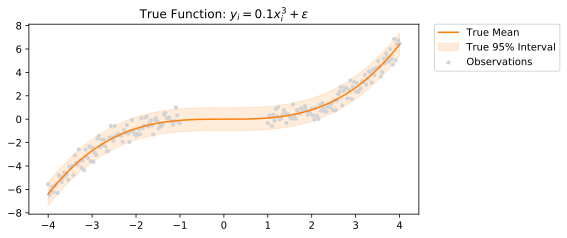

In [31]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x ** 3, scale=0.5)
func.latex = r"$y_i = 0.1x_i^3 + \varepsilon$"

data_points = [
    {"n_points": 100, "xlim": [-4, -1]},
    {"n_points": 100, "xlim": [1, 4]},
]
df = generate_data(func, points=data_points, seed=7)
df_hold = generate_data(func, points=data_points, seed=1)

# Plot the data
plot_true_function(func, df, title=f"True Function: {func.latex}")

# Proper Posterior: Recalibration

We sample from a BNN that produces a reasonably good posterior predictive, both in terms of aleatoric and epistemic uncertainty. After calibration, epistemic uncertainty shrinks, but only slightly. Since our definition of "good" epistemic uncertainty is subjective, the algorithm doesn't seem to ruin a valid model. However, epistemic uncertainty does become more asymmetric than before to calibration:

In [32]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 2.0,
    "noise": 0.5,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params_4k)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

Main dataset: minimum ESS 413.52, maximum Gelman-Rubin 1.01
Hold-out dataset: minimum ESS 530.83, maximum Gelman-Rubin 1.01


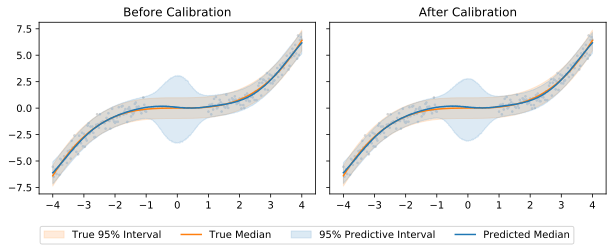

In [33]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# Wrong Prior: Recalibration

The same is true for the posterior predictives that either over- or underestimate uncertainty due to the wrong prior. The calibration algorithm has little effect on epistemic uncertainty:

In [34]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 1.25,
    "noise": 0.5,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params_4k)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

Main dataset: minimum ESS 868.17, maximum Gelman-Rubin 1.00
Hold-out dataset: minimum ESS 589.96, maximum Gelman-Rubin 1.01


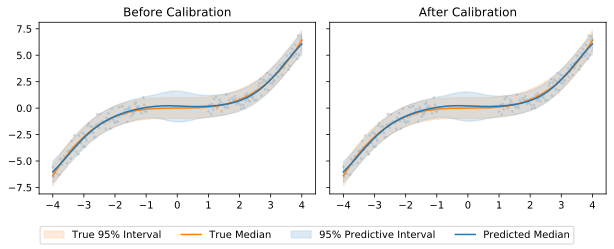

In [35]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# Wrong Noise: Recalibration
  
The situation changes when the noise is specified incorrectly *and* there is missing data. Since the algorithm maps predicted quantiles to empirical ones uniformly across all input space, this calibration method produces perfect aleatoric uncertainty, but reduces epistemic uncertainty drastically:

In [36]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 2.0,
    "noise": 1.0,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

Main dataset: minimum ESS 659.26, maximum Gelman-Rubin 1.01
Hold-out dataset: minimum ESS 654.04, maximum Gelman-Rubin 1.01


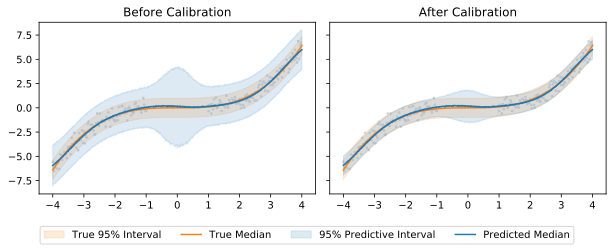

In [37]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# Wrong Noise: Recalibration

Analogously, if aleatoric uncertainty is underestimated by the model, after recalibration, it will be aligned with the data as much as possible, while epistemic uncertainty will be blown up. The authors of the method explicitly state that the suggested approach only works given enough i.i.d. data. Here we see one instance of how it fails:

In [38]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.25,
    "noise": 0.25,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

Main dataset: minimum ESS 179.70, maximum Gelman-Rubin 1.02
Hold-out dataset: minimum ESS 228.69, maximum Gelman-Rubin 1.02


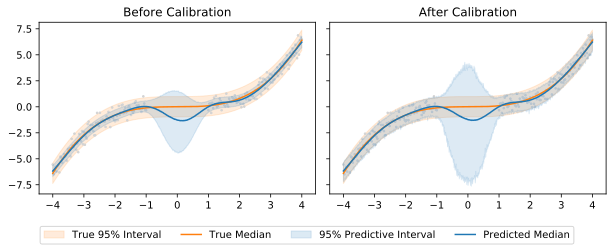

In [39]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# Wrong Likelihood: Recalibration

Another case of failure can be observed in the situation when there is bias, i.e. the network is not sufficiently expressive to describe the data due to a combination of the prior and the architecture. In an effort to fit the data the calibration algorithm increases uncertainty uniformly across the whole input space. A much better approach would be to change the bad model, rather than try to recalibrate it:

In [40]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 0.25,
    "noise": 0.5,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

Main dataset: minimum ESS 145.11, maximum Gelman-Rubin 1.03
Hold-out dataset: minimum ESS 132.20, maximum Gelman-Rubin 1.03


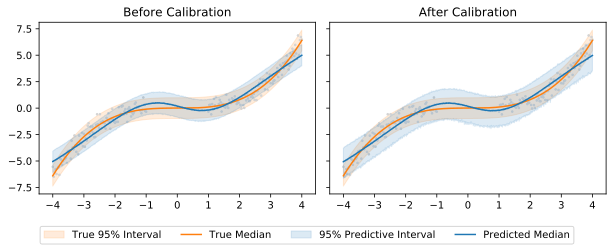

In [41]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# Approximate Inference: Recalibration

Correctly performed Variational Inference using isotropic Gaussians is often associated with underestimated epistemic uncertainty. The quantile-based calibration algorithm does little to such posterior predictives: both epistemic and aleatoric uncertainties mostly remain the same:

In [42]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 2.0,
    "noise": 0.5,
}

vi_params = {
    "num_iter": 500_000,
    "learning_rate": 0.001,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, inference="VI", **model_params, **vi_params)
# Ensure that variational inference has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

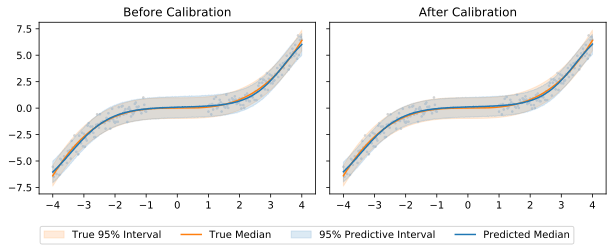

In [43]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# VI with Noise Misspecification: Recalibration

When the variance of the noise in the likelihood is specified incorrectly, the calibration method corrects that, aligning aleatoric uncertainty with the data. The resulting epistemic uncertainty, however, is again too low. The algorithm is unable to remedy the issues arising from variational approximation:

In [44]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 2.0,
    "noise": 1.0,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, inference="VI", **model_params, **vi_params)
# Ensure that variational inference has converged
check_convergence(res_main, res_holdout, func, plot=DEBUG)

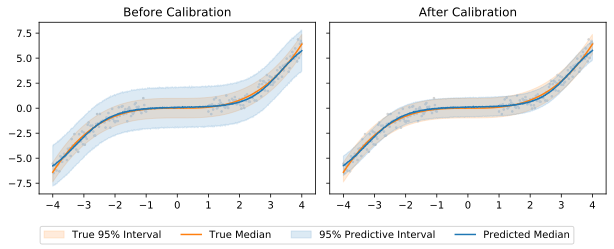

In [45]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=func)

# Heteroscedastic Dataset

The next dataset is generated by the same third-degree polynomial, but with heteroscedastic noise that depends on the value of the predictor $X$. We will model it using a BNN with a constant variance of the noise in the likelihood, and see if the calibration procedure can fix the resulting miscalibrated posterior predictive.

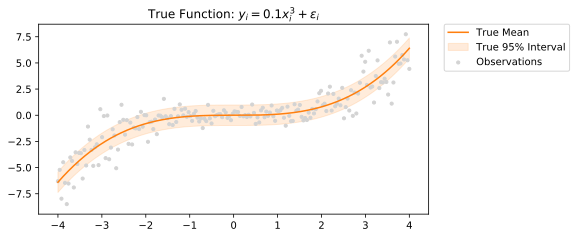

In [46]:
# Define the true function and generate observations
heteroscedastic = lambda x: heteroscedastic_base(x, base_std=0.5)
heteroscedastic.latex = r"$y_i = 0.1x_i^3 + \varepsilon_i$"

data_points = [
    {"n_points": 200, "xlim": [-4, 4]},
]
df = generate_data(heteroscedastic, points=data_points, seed=4)
df_hold = generate_data(heteroscedastic, points=data_points, seed=1)

# Plot the data
plot_true_function(func, df, title=f"True Function: {heteroscedastic.latex}")

# Heteroscedastic Noise: Recalibration

When a BNN is unable to capture heteroscedastic noise, the quantile calibration only makes the posterior predictive worse. The central region of aleatoric uncertainty that the original posterior predictive captured correctly is now inflated. The resulting model might be producing better uncertainty on average, but is less precise in specific segments of the input space:

In [47]:
model_params = {
    "hidden": 1,
    "width": 50,
    "sigma": 1.0,
    "noise": 0.5,
}
# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func=heteroscedastic, plot=DEBUG)

Main dataset: minimum ESS 1,110.21, maximum Gelman-Rubin 1.00
Hold-out dataset: minimum ESS 1,307.29, maximum Gelman-Rubin 1.00


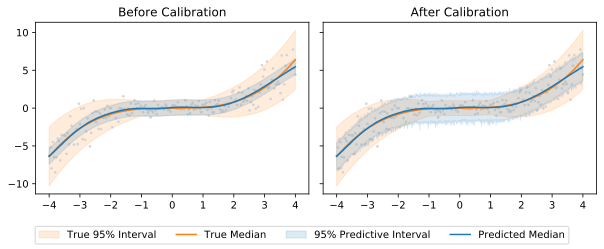

In [48]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=heteroscedastic)

# Discussion: Modeling Heteroscedasticity

Our attempts to model heteroscedasticity by specifying constant noise in the likelihood function of a BNN so far were not very successful. We did observe oscillations of the prediction, but only on datasets with very few points or on artificially constructed datasets that do not occur in real-world scenarios:

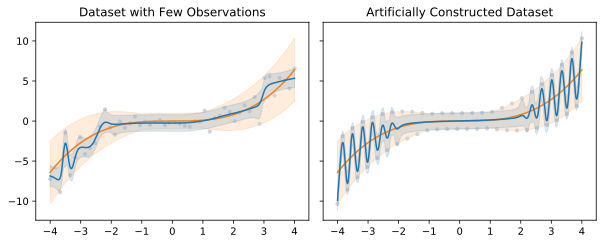

In [49]:
# Generate a heteroscedastic dataset with very few observations
data_points = [{"n_points": 50, "xlim": [-4, 4]}]
df_few = generate_data(heteroscedastic, points=data_points, seed=2)

# Generate another dataset in a special way: with points at the edges
# of the 95% predictive interval, interlaced along the X values:
x_ = np.linspace(-4, 4, num=50)
low_, high_ = heteroscedastic(x_[0::2]).ppf(0.025), heteroscedastic(x_[1::2]).ppf(0.975)
df_special = pd.DataFrame(
    {"x": np.concatenate((x_[0::2], x_[1::2])), "y": np.concatenate((low_, high_))}
)

# Obtain and plot the posterior predictive for both datasets
datasets = [df_few, df_special]
titles = ["Dataset with Few Observations", "Artificially Constructed Dataset"]

fig, ax = plt.subplots(1, 2, figsize=(8.5, 3.5), sharey=True, tight_layout=True)

for axis, data, title in zip(ax, datasets, titles):
    model = build_model(data, width=10, hidden=2, sigma=1.5, noise=0.5)
    mcmc = sample(model, **sampler_params, seed=0, summary=False)
    X_test = np.linspace(data.x.min(), data.x.max(), num=1000)[:, np.newaxis]
    post_pred = simulate_pp(model, mcmc, X_test, seed=1)
    plot_posterior_predictive(
        X_test, post_pred, func=heteroscedastic, df=data, legend=False, ax=axis, title=title
    )

# Non-Gaussian Data

The authors of the paper state that "*if the true data distribution $P(Y | X)$ is not Gaussian, uncertainty estimates derived from the Bayesian model will not be calibrated*". We will construct such a dataset by generating observations with Gamma noise, instead of Normal noise, fit an ordinary BNN to it and see how the proposed calibration algorithm performs:

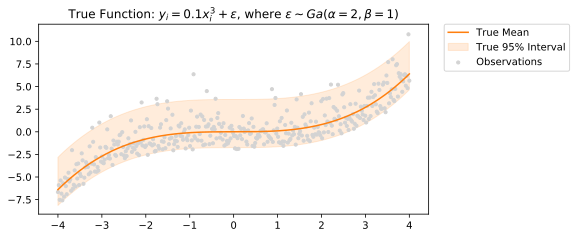

In [52]:
def gamma_polynomial(x):
    """True data-generating function"""
    alpha, beta = 2, 1
    mu = alpha / beta
    return scipy.stats.gamma(alpha, loc=0.1 * x ** 3 - mu, scale=1/beta)

gamma_polynomial.latex = r"$y_i = 0.1x_i^3 + \varepsilon$, where $\varepsilon \sim Ga(\alpha=2, \beta=1)$"

# Generate observations for an equally sized main dataset 
# and a hold-out dataset to train isotonic regression on
data_points = [
    {"n_points": 400, "xlim": [-4, 4]},
]
df = generate_data(gamma_polynomial, points=data_points, seed=4)
df_hold = generate_data(gamma_polynomial, points=data_points, seed=5)

# Plot the data
plot_true_function(gamma_polynomial, df, title=f"True Function: {gamma_polynomial.latex}")

# Non-Gaussian Noise: Recalibration

The simulated posterior predictive obtained from a BNN with a Normal likelihood turns out to be indeed miscalibrated. All of the quantiles including the median are off. After applying the calibration procedure, all of the quantiles are aligned with the data. The non-parametric isotonic regression that lies at the core of the proposed calibration method seems to excel in this setting:

In [ ]:
model_params = {
    "hidden": 1,
    "width": 10,
    "sigma": 1.0,
    # Use the true standard deviation of the noise
    "noise": np.round(gamma_polynomial(0).std(), 1),
}

# Obtain posterior predictives for both datasets and train isotonic regression on the hold-out set
res_main, res_holdout, qc = calibrate(df, df_hold, **model_params, **sampler_params)
# Ensure that the sampler has converged
check_convergence(res_main, res_holdout, func=gamma_polynomial, plot=DEBUG)

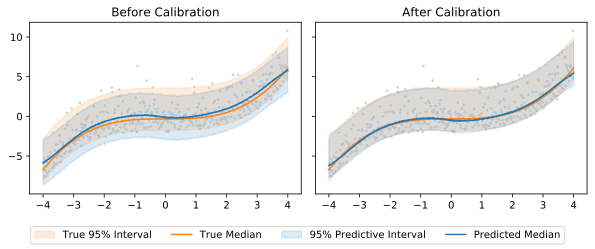

In [55]:
plot_calibration_results(res_main['X_test'], res_main['post_pred'], qc, df=df, func=gamma_polynomial)

# Todo List

- Compute the metrics for all the models (calibration error, PICP, log-likehood)
- Show calibration plots if appropriate
- Evaluate the effect of calibration on point estimates
- Test the algorithm's sensitivity to the amount of i.i.d. data
- Consider using the 90% predictive interval instead of the 95% interval to make the plots more smooth
- Add Evaluation of the claims and Future work